In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv
/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv


Question 1: To what extent is subject age correlated with Alzheimer's disease severity? (measured through the OASIS Study's CDR scale).
In other words, how age related is Alzheimer's disease?

In [4]:
#Importing the cross-sectional CSV data from the OASIS (Alzheimers) Study: 
crossSectionalMRIData = "/kaggle/input/oasis_cross-sectional.csv"
crossSectionalMRI = pd.read_csv("../input/mri-and-alzheimers/oasis_cross-sectional.csv")
crossSectionalMRI.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [5]:
#Importing the Linear Regression Package from Scikit Learn.  
from sklearn.linear_model import LinearRegression 

AgeAndCDRLinearReg = LinearRegression()

#Because there are a number of NaN values in the CDR column, all of the subjects with NaN CDR values will be dropped from the following correlation. 
crossSectionalMRI.dropna(subset = ["CDR","SES","Educ"], axis = 0, inplace = True)
crossSectionalMRI.head()

Age = crossSectionalMRI[['Age']]
CDRScores = crossSectionalMRI[['CDR']]

AgeAndCDRLinearRegModel = AgeAndCDRLinearReg.fit(Age,CDRScores)

AgeAndCDRLinearRegModel.score(Age,CDRScores)

0.09645411487921307

Note: The correlation between Age and CDR scores is actually extremely low within this sample of Alzheimer's patients. Pearson's Coefficient in this case is only ~0.09.

Let's see what this seemingly small relationship looks like on a plot: 







(0.0, 2.11124474335988)

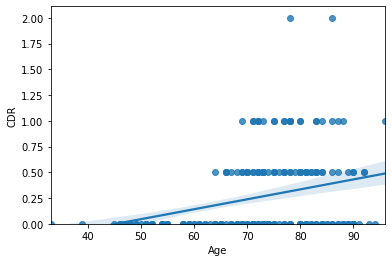

In [6]:
import seaborn as sns 
from matplotlib import pyplot as plt
sns.regplot(x='Age',y='CDR',data=crossSectionalMRI)
plt.ylim(0)

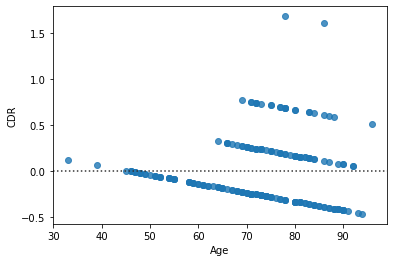

In [7]:
#Let's see what the residuals plot from this model reveals to determine whether a non-linear model would be more revealing:

sns.residplot(crossSectionalMRI['Age'],crossSectionalMRI['CDR'])

#Judging by the above and below plots, it seems like another form of Regression more appropriate for discrete target variables (like Logistic)
#would be more appropriate. Let's try that approach to unravel the relationship between age, SES, Education, and CDR scores.
#Afterwards, let's see if a K-nearest neighbor's model can be built to
#predict whether a subject would depict behaviors and cognition typical of a 0, 0.5, or 1 CDR-scored individual based on 
#multiple feature variables: 

In [8]:
#Let's import some libraries useful for Logistic Regression with Train and Test splitting:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

#Let's check the datatype of the target variable column (CDR): 
before = crossSectionalMRI.dtypes
before
#This column contains data of the type: float64. Let's change that for scikit learn compatability. 

#Let's convert the target data type to integer (as required by scikit learn): 
crossSectionalMRI['CDR'] = crossSectionalMRI['CDR'].astype(int)

#Let's check to ensure the datatype was correctly changed: 
after = crossSectionalMRI.dtypes
after

#Let's convert the Pandas dataframe above into two numpy arrays for more ease of use with scikit learn functions (train/test splitting, etc.): 
crossSectionalMRIFeatures = np.asarray(crossSectionalMRI[['Age','SES','Educ']])
crossSectionalMRITarget = np.asarray(crossSectionalMRI['CDR'])

#Next, let's split the whole dataset into training and testing sets for higher validity: 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(crossSectionalMRIFeatures, crossSectionalMRITarget, test_size=0.2, random_state=4)

#Let's build the Multiple Logistic Regression Model using the training sets 
#and compute some relevant metrics and, perhaps, make a few predictive statements: 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
crossSectionalMRILogistic = LogisticRegression(C=0.01, solver='newton-cg', multi_class='multinomial').fit(X_train,y_train)
crossSectionalMRILogistic

#Finally, let's make a few predictions using this model and the test set, as well as the probability of each of the class targets (0, 0.5, and 1 CDR Scores): 
LogisticAlzhemiersCDRScorePreds = crossSectionalMRILogistic.predict(X_test) 
LogisticAlzhemiersCDRScorePreds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
LogisticAlzheimersCDRScoreProbas = crossSectionalMRILogistic.predict_proba(X_test)
LogisticAlzheimersCDRScoreProbas

array([[9.81441227e-01, 1.80751429e-02, 4.83630139e-04],
       [8.74738475e-01, 1.15055555e-01, 1.02059698e-02],
       [9.34899753e-01, 6.16631628e-02, 3.43708425e-03],
       [8.61063289e-01, 1.25710302e-01, 1.32264096e-02],
       [8.49047124e-01, 1.39481367e-01, 1.14715094e-02],
       [9.52391190e-01, 4.53121484e-02, 2.29666125e-03],
       [8.13676721e-01, 1.68795884e-01, 1.75273950e-02],
       [8.73273098e-01, 1.14104323e-01, 1.26225784e-02],
       [8.20125792e-01, 1.63020559e-01, 1.68536490e-02],
       [9.62355069e-01, 3.59723875e-02, 1.67254330e-03],
       [8.73589307e-01, 1.14096374e-01, 1.23143185e-02],
       [8.82863468e-01, 1.09138266e-01, 7.99826596e-03],
       [9.54369731e-01, 4.34890983e-02, 2.14117073e-03],
       [8.17900835e-01, 1.66638465e-01, 1.54607002e-02],
       [8.84362767e-01, 1.06705975e-01, 8.93125803e-03],
       [8.90501381e-01, 1.00402528e-01, 9.09609148e-03],
       [9.05561217e-01, 8.80640005e-02, 6.37478202e-03],
       [9.30802197e-01, 6.57285

Given that the above probability results indicate an over 60% chance of every prediction landing in the 0 CDR Score category, let's compute a few metrics to determine whether this was a good model for this dataset.

In [10]:
#First, let's look at the Jaccard Similarity score: 
from sklearn.metrics import jaccard_score
y_test
LogisticAlzhemiersCDRScorePreds
jaccard_score(y_test, LogisticAlzhemiersCDRScorePreds)

0.0

[[ 0  4]
 [ 0 40]]
Confusion matrix, without normalization
[[ 0  0  4]
 [ 0  0  0]
 [ 0  0 40]]


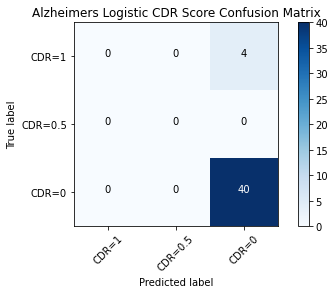

In [11]:
#Next, let's take a look at the specifics of the issue with the Logistic Model here with a Confusion Matrix: 
from sklearn.metrics import classification_report, confusion_matrix

#The following chunk of code (the rest of this code cell)
#was borrowed from the Coursera IBM Professional Certificate Course on Machine Learning (Course 8):

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, LogisticAlzhemiersCDRScorePreds, labels=[1,0]))

AlzheimersLogisticConfusionMatrix = confusion_matrix(y_test, LogisticAlzhemiersCDRScorePreds, labels=[1,0.5,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(AlzheimersLogisticConfusionMatrix, classes=['CDR=1','CDR=0.5','CDR=0'], normalize= False,  title='Alzheimers Logistic CDR Score Confusion Matrix')

Interesting! Unlike the Jaccard Index Score, the results from the 3x3 Confusion Matrix above suggest that the Multiple Logistic Regression Model built correctly classified a total of 40/44 of the train <--> test set comparisons as having a CDR of 0.

Now, let's build a K-Nearest Neighbors Model to predict whether a new subject will have a CDR of 0, 0.5, or 1 based on their Age, 
SES, and Education Level. 

In [28]:
#First, let's make the necessary imports to implement the K Nearest Neighbors Classification Algorithm with scikit learn and determine 
#the value of K resulting in the highest accuracy classification score: 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 


AlzNeighborsAccuracyArray = np.zeros(19)
kTestIterationList = range(1,20,1)
for k in kTestIterationList:

    AlzCDRNeighbors = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    AlzPredictions=AlzCDRNeighbors.predict(X_test)
    AlzNeighborsAccuracyArray[k-1]=metrics.accuracy_score(y_test,AlzPredictions)

array([0.75, 0.91, 0.91, 0.91, 0.93, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91,
       0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91])